In [12]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_35.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_35.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


In [13]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [14]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [15]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [16]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]


In [18]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:04<00:00,  3.62it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:06<00:00, 34.63it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:24<00:00,  2.86it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:05<00:00, 43.05it/s]


In [19]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   2%|▏         | 10/500 [00:06<05:22,  1.52it/s]

Epoch 10/500, Loss: 1.4186
Test Accuracy at Epoch 10: 58.27%
Test F1-score at Epoch 10: 0.3457
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.56      0.92      0.69       195
non_infringement       0.74      0.23      0.35       186

        accuracy                           0.58       381
       macro avg       0.65      0.57      0.52       381
    weighted avg       0.64      0.58      0.52       381

New best model saved with F1-score 0.3457 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.56      0.92      0.69       195
non_infringement       0.74      0.23      0.35       186

        accuracy                           0.58       381
       macro avg       0.65      0.57      0.52       381
    weighted avg       0.64      0.58      0.52       381



Training Epochs:   4%|▍         | 20/500 [00:11<03:16,  2.45it/s]

Epoch 20/500, Loss: 0.5475
Test Accuracy at Epoch 20: 59.84%
Test F1-score at Epoch 20: 0.3953
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.57      0.91      0.70       195
non_infringement       0.75      0.27      0.40       186

        accuracy                           0.60       381
       macro avg       0.66      0.59      0.55       381
    weighted avg       0.65      0.60      0.55       381

New best model saved with F1-score 0.3953 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.57      0.91      0.70       195
non_infringement       0.75      0.27      0.40       186

        accuracy                           0.60       381
       macro avg       0.66      0.59      0.55       381
    weighted avg       0.65      0.60      0.55       381



Training Epochs:   6%|▌         | 30/500 [00:16<04:46,  1.64it/s]

Epoch 30/500, Loss: 0.5149
Test Accuracy at Epoch 30: 69.29%
Test F1-score at Epoch 30: 0.6667
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.68      0.75      0.72       195
non_infringement       0.71      0.63      0.67       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381

New best model saved with F1-score 0.6667 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.68      0.75      0.72       195
non_infringement       0.71      0.63      0.67       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:   8%|▊         | 40/500 [00:18<01:09,  6.63it/s]

Epoch 40/500, Loss: 0.4856
Test Accuracy at Epoch 40: 68.77%
Test F1-score at Epoch 40: 0.6685
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.68      0.73      0.70       195
non_infringement       0.69      0.65      0.67       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381

New best model saved with F1-score 0.6685 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.68      0.73      0.70       195
non_infringement       0.69      0.65      0.67       186

        accuracy                           0.69       381
       macro avg       0.69      0.69      0.69       381
    weighted avg       0.69      0.69      0.69       381



Training Epochs:  10%|█         | 50/500 [00:24<04:28,  1.67it/s]

Epoch 50/500, Loss: 0.4583
Test Accuracy at Epoch 50: 70.60%
Test F1-score at Epoch 50: 0.7419
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.81      0.55      0.66       195
non_infringement       0.65      0.87      0.74       186

        accuracy                           0.71       381
       macro avg       0.73      0.71      0.70       381
    weighted avg       0.73      0.71      0.70       381

New best model saved with F1-score 0.7419 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.81      0.55      0.66       195
non_infringement       0.65      0.87      0.74       186

        accuracy                           0.71       381
       macro avg       0.73      0.71      0.70       381
    weighted avg       0.73      0.71      0.70       381



Training Epochs:  12%|█▏        | 60/500 [00:27<01:21,  5.40it/s]

Epoch 60/500, Loss: 0.4137
Test Accuracy at Epoch 60: 72.97%
Test F1-score at Epoch 60: 0.7392
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       195
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       381
       macro avg       0.73      0.73      0.73       381
    weighted avg       0.73      0.73      0.73       381



Training Epochs:  14%|█▎        | 68/500 [00:28<00:31, 13.80it/s]

Epoch 70/500, Loss: 0.3570
Test Accuracy at Epoch 70: 73.75%
Test F1-score at Epoch 70: 0.7487
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       195
non_infringement       0.70      0.80      0.75       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381

New best model saved with F1-score 0.7487 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       195
non_infringement       0.70      0.80      0.75       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  17%|█▋        | 84/500 [00:32<00:52,  7.98it/s]

Epoch 80/500, Loss: 0.3011
Test Accuracy at Epoch 80: 71.13%
Test F1-score at Epoch 80: 0.6910
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.70      0.76      0.73       195
non_infringement       0.72      0.66      0.69       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  18%|█▊        | 89/500 [00:34<01:55,  3.55it/s]

Epoch 90/500, Loss: 0.2776
Test Accuracy at Epoch 90: 71.65%
Test F1-score at Epoch 90: 0.6842
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.69      0.80      0.74       195
non_infringement       0.75      0.63      0.68       186

        accuracy                           0.72       381
       macro avg       0.72      0.71      0.71       381
    weighted avg       0.72      0.72      0.71       381



Training Epochs:  20%|██        | 100/500 [00:41<03:48,  1.75it/s]

Epoch 100/500, Loss: 0.2469
Test Accuracy at Epoch 100: 72.70%
Test F1-score at Epoch 100: 0.7234
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.74      0.72      0.73       195
non_infringement       0.72      0.73      0.72       186

        accuracy                           0.73       381
       macro avg       0.73      0.73      0.73       381
    weighted avg       0.73      0.73      0.73       381



Training Epochs:  22%|██▏       | 110/500 [00:42<00:42,  9.28it/s]

Epoch 110/500, Loss: 0.2173
Test Accuracy at Epoch 110: 71.13%
Test F1-score at Epoch 110: 0.6961
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.71      0.74      0.72       195
non_infringement       0.72      0.68      0.70       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  24%|██▍       | 120/500 [00:48<03:45,  1.68it/s]

Epoch 120/500, Loss: 0.1970
Test Accuracy at Epoch 120: 74.02%
Test F1-score at Epoch 120: 0.7388
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       195
non_infringement       0.73      0.75      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  26%|██▌       | 130/500 [00:52<01:24,  4.37it/s]

Epoch 130/500, Loss: 0.2103
Test Accuracy at Epoch 130: 71.39%
Test F1-score at Epoch 130: 0.6997
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.71      0.74      0.73       195
non_infringement       0.72      0.68      0.70       186

        accuracy                           0.71       381
       macro avg       0.71      0.71      0.71       381
    weighted avg       0.71      0.71      0.71       381



Training Epochs:  29%|██▉       | 144/500 [00:53<00:22, 15.51it/s]

Epoch 140/500, Loss: 0.1746
Test Accuracy at Epoch 140: 74.28%
Test F1-score at Epoch 140: 0.7448
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       195
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  30%|███       | 151/500 [00:53<00:18, 19.34it/s]

Epoch 150/500, Loss: 0.1560
Test Accuracy at Epoch 150: 74.28%
Test F1-score at Epoch 150: 0.7421
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       195
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  33%|███▎      | 164/500 [00:54<00:12, 26.01it/s]

Epoch 160/500, Loss: 0.1996
Test Accuracy at Epoch 160: 71.92%
Test F1-score at Epoch 160: 0.6934
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.70      0.78      0.74       195
non_infringement       0.74      0.65      0.69       186

        accuracy                           0.72       381
       macro avg       0.72      0.72      0.72       381
    weighted avg       0.72      0.72      0.72       381



Training Epochs:  34%|███▍      | 172/500 [00:54<00:11, 29.78it/s]

Epoch 170/500, Loss: 0.1571
Test Accuracy at Epoch 170: 72.70%
Test F1-score at Epoch 170: 0.7174
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.73      0.74      0.74       195
non_infringement       0.73      0.71      0.72       186

        accuracy                           0.73       381
       macro avg       0.73      0.73      0.73       381
    weighted avg       0.73      0.73      0.73       381



Training Epochs:  35%|███▌      | 176/500 [00:54<00:11, 28.84it/s]

Epoch 180/500, Loss: 0.1325
Test Accuracy at Epoch 180: 75.59%
Test F1-score at Epoch 180: 0.7597
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       195
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



Training Epochs:  36%|███▌      | 180/500 [00:55<00:28, 11.34it/s]

New best model saved with F1-score 0.7597 at epoch 180
Best Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       195
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



Training Epochs:  38%|███▊      | 190/500 [01:01<02:23,  2.17it/s]

Epoch 190/500, Loss: 0.1247
Test Accuracy at Epoch 190: 72.18%
Test F1-score at Epoch 190: 0.7104
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.72      0.74      0.73       195
non_infringement       0.72      0.70      0.71       186

        accuracy                           0.72       381
       macro avg       0.72      0.72      0.72       381
    weighted avg       0.72      0.72      0.72       381



Training Epochs:  41%|████      | 204/500 [01:02<00:22, 12.95it/s]

Epoch 200/500, Loss: 0.1160
Test Accuracy at Epoch 200: 71.92%
Test F1-score at Epoch 200: 0.7084
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.72      0.74      0.73       195
non_infringement       0.72      0.70      0.71       186

        accuracy                           0.72       381
       macro avg       0.72      0.72      0.72       381
    weighted avg       0.72      0.72      0.72       381



Training Epochs:  42%|████▏     | 210/500 [01:03<00:40,  7.19it/s]

Epoch 210/500, Loss: 0.1180
Test Accuracy at Epoch 210: 76.12%
Test F1-score at Epoch 210: 0.7661
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.76       195
non_infringement       0.73      0.80      0.77       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381

New best model saved with F1-score 0.7661 at epoch 210
Best Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.76       195
non_infringement       0.73      0.80      0.77       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



Training Epochs:  44%|████▍     | 220/500 [01:09<02:16,  2.05it/s]

Epoch 220/500, Loss: 0.1838
Test Accuracy at Epoch 220: 75.85%
Test F1-score at Epoch 220: 0.7566
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       195
non_infringement       0.74      0.77      0.76       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



Training Epochs:  47%|████▋     | 234/500 [01:10<00:21, 12.19it/s]

Epoch 230/500, Loss: 0.1108
Test Accuracy at Epoch 230: 72.97%
Test F1-score at Epoch 230: 0.7147
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.72      0.76      0.74       195
non_infringement       0.74      0.69      0.71       186

        accuracy                           0.73       381
       macro avg       0.73      0.73      0.73       381
    weighted avg       0.73      0.73      0.73       381



Training Epochs:  48%|████▊     | 241/500 [01:10<00:18, 14.10it/s]

Epoch 240/500, Loss: 0.1129
Test Accuracy at Epoch 240: 73.75%
Test F1-score at Epoch 240: 0.7368
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.74       195
non_infringement       0.72      0.75      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  50%|█████     | 250/500 [01:14<01:39,  2.52it/s]

Epoch 250/500, Loss: 0.1026
Test Accuracy at Epoch 250: 74.02%
Test F1-score at Epoch 250: 0.7402
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       195
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  52%|█████▏    | 260/500 [01:18<02:01,  1.97it/s]

Epoch 260/500, Loss: 0.0990
Test Accuracy at Epoch 260: 73.49%
Test F1-score at Epoch 260: 0.7335
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.74       195
non_infringement       0.72      0.75      0.73       186

        accuracy                           0.73       381
       macro avg       0.74      0.74      0.73       381
    weighted avg       0.74      0.73      0.73       381



Training Epochs:  54%|█████▍    | 272/500 [01:20<00:28,  8.12it/s]

Epoch 270/500, Loss: 0.0945
Test Accuracy at Epoch 270: 73.75%
Test F1-score at Epoch 270: 0.7340
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.75      0.73      0.74       195
non_infringement       0.73      0.74      0.73       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  56%|█████▌    | 279/500 [01:21<00:17, 12.85it/s]

Epoch 280/500, Loss: 0.0921
Test Accuracy at Epoch 280: 73.75%
Test F1-score at Epoch 280: 0.7340
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.75      0.73      0.74       195
non_infringement       0.73      0.74      0.73       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  59%|█████▉    | 294/500 [01:23<00:14, 14.30it/s]

Epoch 290/500, Loss: 0.0895
Test Accuracy at Epoch 290: 73.75%
Test F1-score at Epoch 290: 0.7326
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.75      0.74      0.74       195
non_infringement       0.73      0.74      0.73       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  60%|█████▉    | 298/500 [01:23<00:10, 18.63it/s]

Epoch 300/500, Loss: 0.0878
Test Accuracy at Epoch 300: 74.02%
Test F1-score at Epoch 300: 0.7360
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.75      0.74      0.74       195
non_infringement       0.73      0.74      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  62%|██████▏   | 310/500 [01:29<01:38,  1.93it/s]

Epoch 310/500, Loss: 0.0934
Test Accuracy at Epoch 310: 75.07%
Test F1-score at Epoch 310: 0.7493
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       195
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  64%|██████▍   | 320/500 [01:33<00:40,  4.50it/s]

Epoch 320/500, Loss: 0.0878
Test Accuracy at Epoch 320: 74.02%
Test F1-score at Epoch 320: 0.7374
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.75      0.73      0.74       195
non_infringement       0.73      0.75      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  67%|██████▋   | 333/500 [01:33<00:12, 12.95it/s]

Epoch 330/500, Loss: 0.0896
Test Accuracy at Epoch 330: 74.80%
Test F1-score at Epoch 330: 0.7474
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.75       195
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  68%|██████▊   | 341/500 [01:37<00:37,  4.22it/s]

Epoch 340/500, Loss: 0.0876
Test Accuracy at Epoch 340: 74.80%
Test F1-score at Epoch 340: 0.7474
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.75       195
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  71%|███████   | 354/500 [01:37<00:09, 15.96it/s]

Epoch 350/500, Loss: 0.0871
Test Accuracy at Epoch 350: 72.70%
Test F1-score at Epoch 350: 0.7174
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.73      0.74      0.74       195
non_infringement       0.73      0.71      0.72       186

        accuracy                           0.73       381
       macro avg       0.73      0.73      0.73       381
    weighted avg       0.73      0.73      0.73       381



Training Epochs:  73%|███████▎  | 364/500 [01:38<00:06, 22.52it/s]

Epoch 360/500, Loss: 0.0843
Test Accuracy at Epoch 360: 74.54%
Test F1-score at Epoch 360: 0.7441
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.75       195
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  74%|███████▍  | 371/500 [01:38<00:05, 24.16it/s]

Epoch 370/500, Loss: 0.0834
Test Accuracy at Epoch 370: 73.49%
Test F1-score at Epoch 370: 0.7292
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.74      0.74      0.74       195
non_infringement       0.73      0.73      0.73       186

        accuracy                           0.73       381
       macro avg       0.73      0.73      0.73       381
    weighted avg       0.73      0.73      0.73       381



Training Epochs:  76%|███████▌  | 380/500 [01:43<00:45,  2.63it/s]

Epoch 380/500, Loss: 0.0825
Test Accuracy at Epoch 380: 75.59%
Test F1-score at Epoch 380: 0.7572
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       195
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



Training Epochs:  78%|███████▊  | 391/500 [01:45<00:16,  6.64it/s]

Epoch 390/500, Loss: 0.0882
Test Accuracy at Epoch 390: 71.92%
Test F1-score at Epoch 390: 0.7068
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.72      0.74      0.73       195
non_infringement       0.72      0.69      0.71       186

        accuracy                           0.72       381
       macro avg       0.72      0.72      0.72       381
    weighted avg       0.72      0.72      0.72       381



Training Epochs:  80%|████████  | 400/500 [01:47<00:29,  3.44it/s]

Epoch 400/500, Loss: 0.0842
Test Accuracy at Epoch 400: 75.33%
Test F1-score at Epoch 400: 0.7552
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       195
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  82%|████████▏ | 410/500 [01:52<00:50,  1.78it/s]

Epoch 410/500, Loss: 0.0866
Test Accuracy at Epoch 410: 71.92%
Test F1-score at Epoch 410: 0.7068
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.72      0.74      0.73       195
non_infringement       0.72      0.69      0.71       186

        accuracy                           0.72       381
       macro avg       0.72      0.72      0.72       381
    weighted avg       0.72      0.72      0.72       381



Training Epochs:  84%|████████▍ | 420/500 [01:58<00:50,  1.58it/s]

Epoch 420/500, Loss: 0.0858
Test Accuracy at Epoch 420: 75.33%
Test F1-score at Epoch 420: 0.7552
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       195
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  86%|████████▌ | 430/500 [02:04<00:44,  1.59it/s]

Epoch 430/500, Loss: 0.0924
Test Accuracy at Epoch 430: 71.92%
Test F1-score at Epoch 430: 0.7068
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.72      0.74      0.73       195
non_infringement       0.72      0.69      0.71       186

        accuracy                           0.72       381
       macro avg       0.72      0.72      0.72       381
    weighted avg       0.72      0.72      0.72       381



Training Epochs:  88%|████████▊ | 440/500 [02:09<00:33,  1.79it/s]

Epoch 440/500, Loss: 0.0879
Test Accuracy at Epoch 440: 75.33%
Test F1-score at Epoch 440: 0.7552
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       195
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  91%|█████████ | 453/500 [02:11<00:05,  9.34it/s]

Epoch 450/500, Loss: 0.0918
Test Accuracy at Epoch 450: 72.44%
Test F1-score at Epoch 450: 0.7139
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.72      0.74      0.73       195
non_infringement       0.72      0.70      0.71       186

        accuracy                           0.72       381
       macro avg       0.72      0.72      0.72       381
    weighted avg       0.72      0.72      0.72       381



Training Epochs:  93%|█████████▎| 463/500 [02:12<00:02, 17.07it/s]

Epoch 460/500, Loss: 0.0853
Test Accuracy at Epoch 460: 75.59%
Test F1-score at Epoch 460: 0.7572
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       195
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



Training Epochs:  94%|█████████▎| 468/500 [02:12<00:01, 23.88it/s]

Epoch 470/500, Loss: 0.0808
Test Accuracy at Epoch 470: 74.80%
Test F1-score at Epoch 470: 0.7474
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.75       195
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       381
       macro avg       0.75      0.75      0.75       381
    weighted avg       0.75      0.75      0.75       381



Training Epochs:  96%|█████████▌| 480/500 [02:18<00:09,  2.18it/s]

Epoch 480/500, Loss: 0.0799
Test Accuracy at Epoch 480: 74.28%
Test F1-score at Epoch 480: 0.7407
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       195
non_infringement       0.73      0.75      0.74       186

        accuracy                           0.74       381
       macro avg       0.74      0.74      0.74       381
    weighted avg       0.74      0.74      0.74       381



Training Epochs:  99%|█████████▊| 493/500 [02:19<00:00, 11.49it/s]

Epoch 490/500, Loss: 0.0802
Test Accuracy at Epoch 490: 75.59%
Test F1-score at Epoch 490: 0.7572
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       195
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



Training Epochs: 100%|██████████| 500/500 [02:19<00:00,  3.57it/s]
/tmp/ipykernel_4097109/1065145070.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.0831
Test Accuracy at Epoch 500: 73.49%
Test F1-score at Epoch 500: 0.7292
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.74      0.74      0.74       195
non_infringement       0.73      0.73      0.73       186

        accuracy                           0.73       381
       macro avg       0.73      0.73      0.73       381
    weighted avg       0.73      0.73      0.73       381



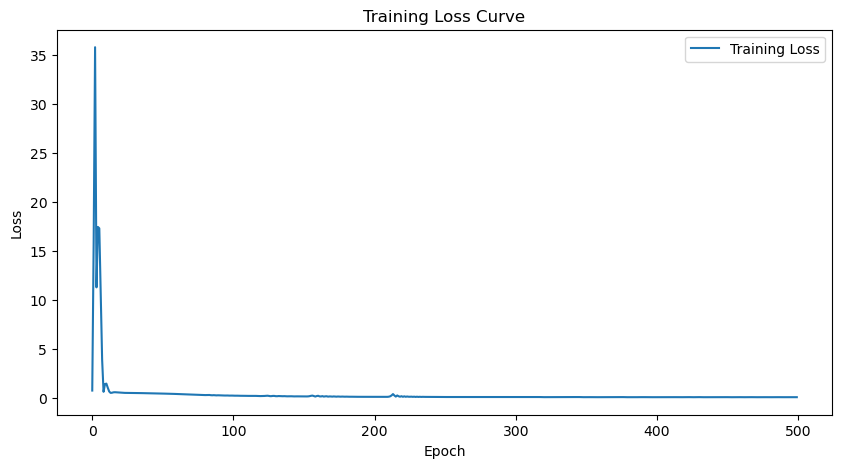

Final Model Accuracy: 76.12%
Final Model F1-score: 0.7661


In [20]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [21]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [22]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.79      0.72      0.76       195
non_infringement       0.73      0.80      0.77       186

        accuracy                           0.76       381
       macro avg       0.76      0.76      0.76       381
    weighted avg       0.76      0.76      0.76       381



/tmp/ipykernel_4097109/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
